In [1]:
import pyvisa as pv
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio   
import pickle
import scipy.signal
from tqdm.notebook import tqdm, trange
from scipy.special import erfc
import scipy as sp
from optic.comm.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp.core import firFilter, pulseShape, lowPassFIR, pnorm, upsample
from optic.comm.metrics import signal_power,fastBERcalc

from optic.plot import eyediagram
plt.rcParams["figure.figsize"] = (12,6)

from funcoesLab import *

In [5]:
def Onda_Dac(DAC,Porta,fs,V_High,V_Low,pontos,filtro):
    DAC.write(f':SOURce{Porta}:FUNCtion:SEQuence:STATe ON')
    DAC.write(f':SOURce{Porta}:FUNCtion:SEQuence:LIST:CLEar')
    tamanhopacote = 300
    simboloscortados = np.array_split(pontos,int(np.ceil(len(pontos)/tamanhopacote)))
    if len(simboloscortados) == 1:
        pontos = np.array2string(simboloscortados[0], separator=', ').translate({ord(j): None for j in '[]'}).replace('\n','')
        DAC.write(f':SOURce{Porta}:TRACe:DATA:DAC16 CODE,END, {pontos}')
        DAC.query('*OPC?')
    else:
        for i in range(len(simboloscortados)):
            pontos = np.array2string(simboloscortados[i], separator=', ').translate({ord(j): None for j in '[]'}).replace('\n','')
            if i == 0:
                DAC.write(f':SOURce{Porta}:TRACe:DATA:DAC16 CODE,HEADer, {pontos}')
                DAC.query('*OPC?')        
            elif i == len(simboloscortados) - 1:
                DAC.write(f':SOURce{Porta}:TRACe:DATA:DAC16 CODE,END, {pontos}')
                DAC.query('*OPC?')
            else:
                DAC.write(f':SOURce{Porta}:TRACe:DATA:DAC16 CODE,CONTinue, {pontos}')
                DAC.query('*OPC?')

In [15]:
#Conectar
rm = pv.ResourceManager()
print(rm.list_resources())

DAC = rm.open_resource('USB0::0x1AB1::0x0646::DG9R261500165::0::INSTR')
print('info DAC:', DAC.query('*IDN?'))

DAC.write('*rst')
DAC.write('*opc?') 

scope = rm.open_resource('USB0::0x2A8D::0x1768::MY55440748::0::INSTR')
print('Info Osciloscopio:', scope.query('*IDN?'))
scope.write('*rst')
scope.write('*opc?') 

print('')

('USB0::0x1AB1::0x0646::DG9R261500165::0::INSTR', 'USB0::0x2A8D::0x1768::MY55440748::0::INSTR')
info DAC: RIGOL TECHNOLOGIES,DG922 Pro,DG9R261500165,00.01.00.00.21 

Info Osciloscopio: KEYSIGHT TECHNOLOGIES,DSO-X 3014T,MY55440748,04.06.2015051201




In [32]:
#Encerrar
DAC.close()
scope.close()
rm.close()


In [14]:
def Onda_Dac(DAC,Porta,fs,V_High,V_Low,pontos,filtro):
    #DAC.write(f':SOURce{Porta}:FUNCtion:SEQuence:STATe ON')
    #DAC.write(f':SOURce{Porta}:FUNCtion:SEQuence:LIST:CLEar')
    tamanhopacote = 2000
    simboloscortados = np.array_split(pontos,int(np.ceil(len(pontos)/tamanhopacote)))
    #DAC.write(f':SOURce2:FUNCtion:SEQuence:LIST:CLEar')
    if len(simboloscortados) == 1:
        pontos = np.ndarray.tolist(simboloscortados[0])
        try:
            DAC.write_binary_values(f':SOURce{Porta}:TRACe:DATA:DAC16 BIN,END,', pontos,datatype='h')
            DAC.query('*OPC?')
        except:
                    print('tentando novamente')
                    #DAC.write(f':SOURce{Porta}:TRACe:DATA:DAC16 CODE,CONTinue, {pontos}')
                    DAC.query('*OPC?')
    else:
        for i in range(len(simboloscortados)):
            pontos = simboloscortados[i]
            if i == 0:
                try:
                    DAC.write_binary_values(f':SOURce{Porta}:TRACe:DATA:DAC16 BIN,HEADer,', pontos,datatype='h')
                    DAC.query('*OPC?')       
                except:
                    print(f'{i/len(simboloscortados)*100}%')
                    #DAC.write(f':SOURce{Porta}:TRACe:DATA:DAC16 CODE,CONTinue, {pontos}')
                    DAC.query('*OPC?') 
            elif i == len(simboloscortados) - 1:
                try:
                    DAC.write_binary_values(f':SOURce{Porta}:TRACe:DATA:DAC16 BIN,END,', pontos,datatype='h')
                    DAC.query('*OPC?')
                except:
                    print(f'{i/len(simboloscortados)*100}%')
                    #DAC.write(f':SOURce{Porta}:TRACe:DATA:DAC16 CODE,CONTinue, {pontos}')
                    DAC.query('*OPC?')
            else:
                try:
                    DAC.write_binary_values(f':SOURce{Porta}:TRACe:DATA:DAC16 BIN,CONTinue,', pontos,datatype='h')
                    DAC.query('*OPC?')
                except:
                    print(f'{i/len(simboloscortados)*100}%')

                    #DAC.write(f':SOURce{Porta}:TRACe:DATA:DAC16 CODE,CONTinue, {pontos}')
                    DAC.query('*OPC?')

    DAC.write(f':SOURce{Porta}:FUNCtion:SEQuence:LIST:SRATe {fs}')
    DAC.write(f':SOURce{Porta}:FUNCtion:SEQuence:LIST:FILTer {filtro}')
    DAC.write(f':SOURce{Porta}:FUNCtion:SEQuence:LIST:APPLy')

    DAC.write(f':SOURce{Porta}:VOLTage:HIGH {V_High}')
    DAC.write(f':SOURce{Porta}:VOLTage:LOW {V_Low}')
    DAC.write(f':OUTPut{Porta}:STATe ON')


In [31]:
# DAC.write('*rst')

# DAC.write('*opc?')

# scope.write('*rst')
# scope.write('*opc?') 
#Valores Geração do sinal
M = 4 # order of the modulation format
nsimbolos = 20000
SPS = 4
formatoPulso = 'rrc' #'rect','nrz','rrc'
nTaps = 1024
alpha = 0.01

bits,simbolos = Gerar_Simbolos(M,nsimbolos,SPS,formatoPulso,nTaps,alpha)
#Gerando uma onda arbitraria no DAC
DAC = DAC
Porta = 2
fs = 75e6
V_High = 4
V_Low = 0
pontos = simbolos
filtro = 'NORMAL'

DAC.write(f':SOURce{Porta}:FUNCtion:SEQuence:STATe ON')
try:
    DAC.query('*OPC?')
except:
    DAC.query('*OPC?')  
Onda_Dac(DAC,Porta,SPS*fs,V_High,V_Low,pontos,filtro)
#ref = 32000*np.append(np.ones(1),-1*np.ones(nsimbolos-1))
#Onda_Dac(DAC,1,fs,V_High,V_Low,ref,filtro)
#DAC.write(':SOURce1:PHASe:SYNChronize')
#DAC.write(':SOURce2:PHASe:SYNChronize')
#
#print(DAC.read())

#DAC.query('*OPC?')   
#Configurar O osciloscopio
tempo = nsimbolos/(fs)
canais = np.array([2])
vDivisao = np.array([0.6])
impedancia = np.array(['ONEMeg'])
trigger = np.array([0])
offset = np.array([2])
# ConfigurarScope(scope,tempo,canais,vDivisao,impedancia,trigger,offset)
# # #Plotar o sinal
# scope.write(':WAVeform:POINts:MODE RAW')
# #scope.write(':WAVeform:POINts: 20000')
# scope.write('digitize')
# try:
#     scope.query('*OPC?')   
# except:
#     time.sleep(5)
#     scope.query('*OPC?')   

# scope.write(f'waveform:source channel3')
# scope.write('waveform:format byte')
# scope.write(":WAVeform:POINts:MODE RAW")
# scope.write(':WAVeform:POINts 1400000')

# #simbolosTransmitidos,simbolosrecebidos = DemodularSinal(scope,3,2,V_High,nsimbolos,SPS,simbolos,True)
# #ber, ser, snr = fastBERcalc(simbolosrecebidos,simbolosTransmitidos,4,'pam')
# #print('Ber = ' + str(ber[0]))


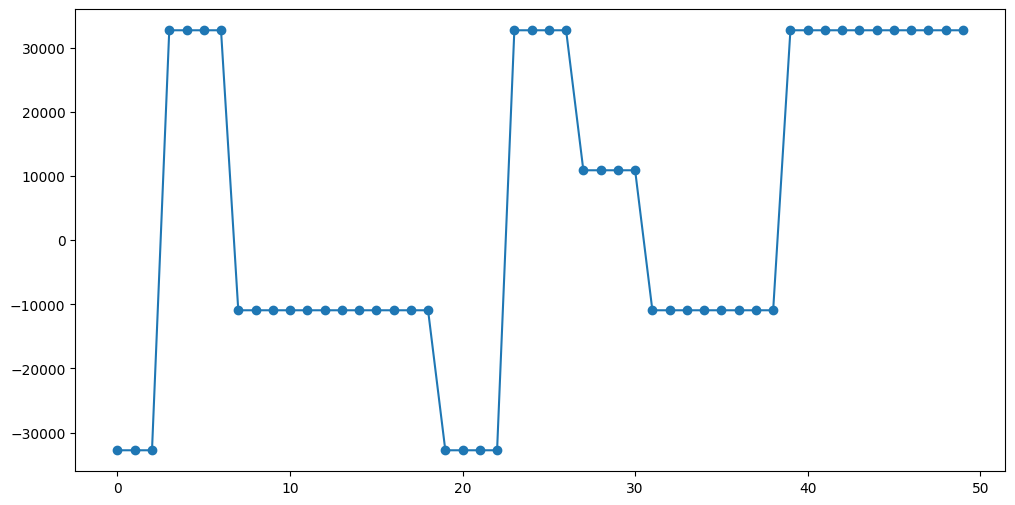

In [21]:
plt.plot(simbolos[0:50],'-o')

In [ ]:
#scope.write(':WAVeform:POINts 1400000')
scope.query(':WAVeform:POINts?')

Numero de pontos do osciloscopio: 1300000
Amostras por simbolo do osciloscopio: 2.0
Janela de tempo do Osciloscopio: 649.999 ms
Frequencia de amostragem do osciloscopio: 2.0 MHz
Resultados
Numero de erros: 52103
ber: 0.04007923076923077


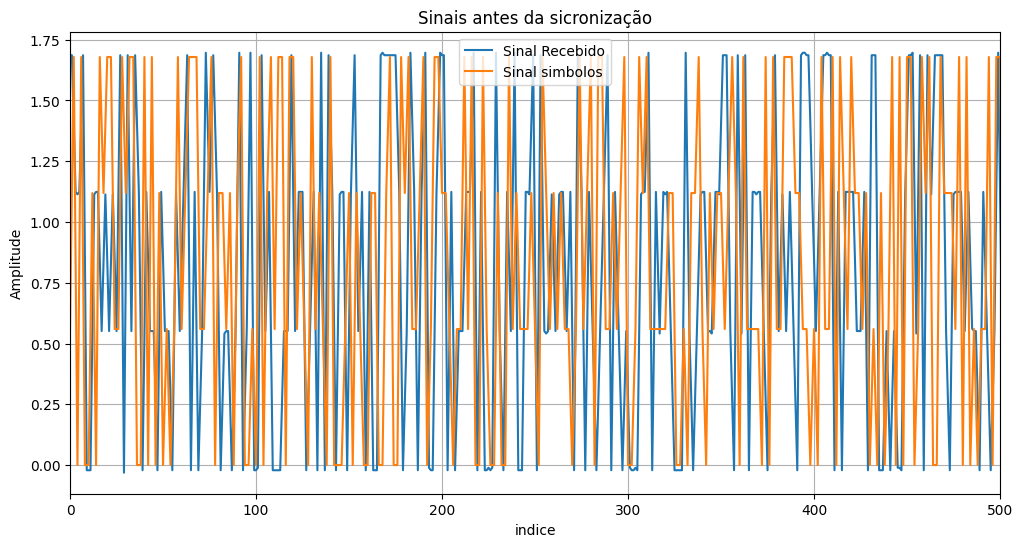

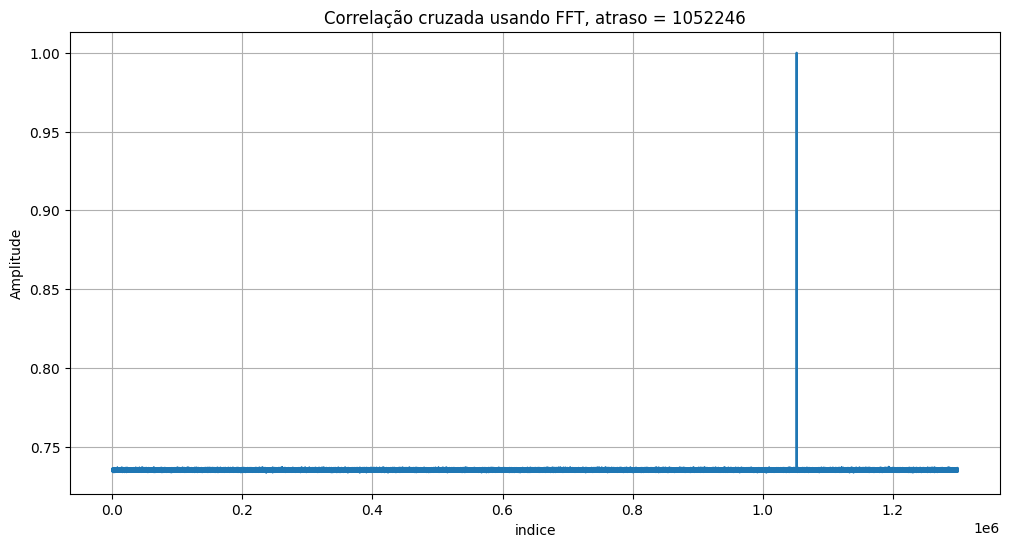

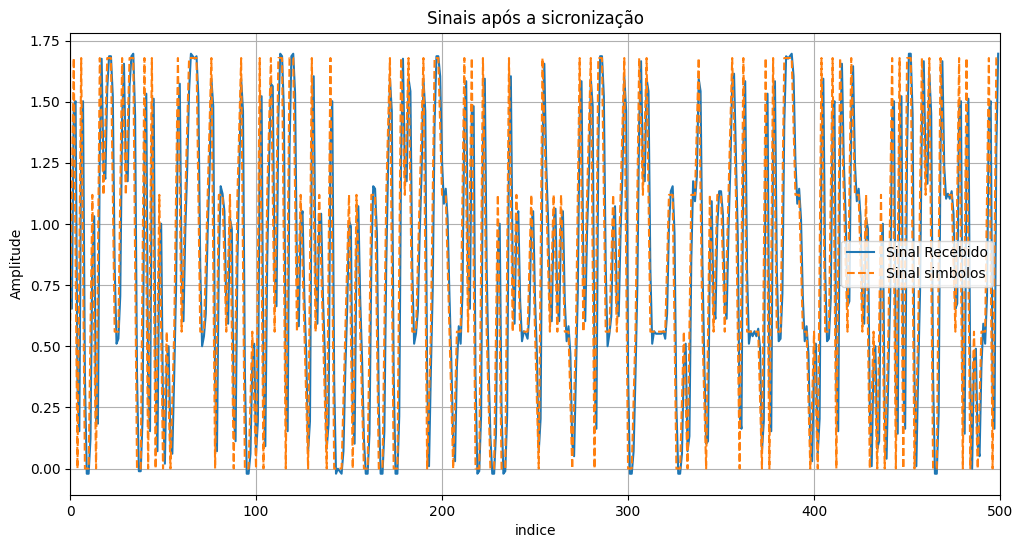

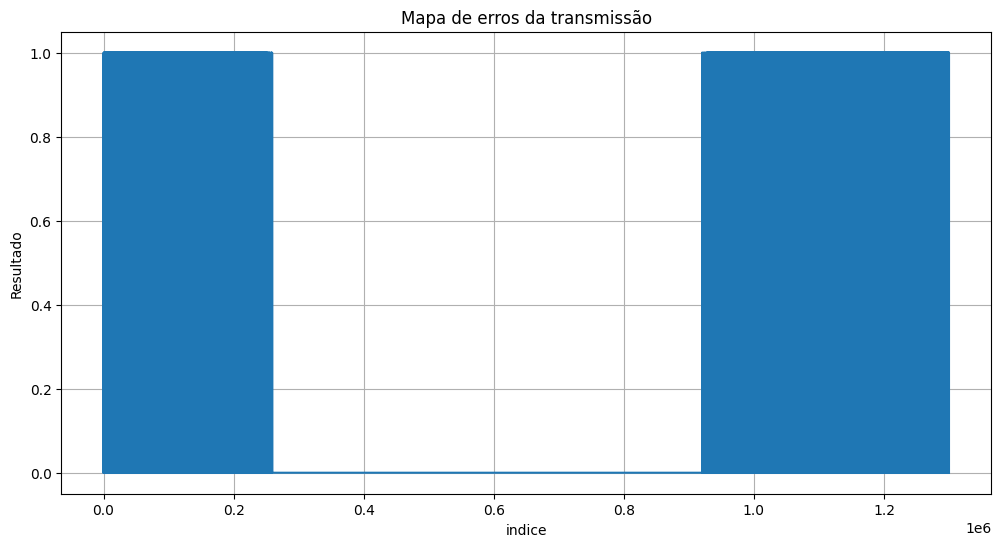

In [816]:
def periodic_corr(x, y):
    from numpy.fft import fft, ifft
    """Periodic correlation, implemented using the FFT.

    x and y must be real sequences with the same length.
    """
    return (ifft(fft(x) * fft(y).conj()).real)
scope.write(':WAVeform:POINts 1300000')

dados = scope.query_binary_values('waveform:    ?', datatype='B')

nDados = len(dados)


tInicial = float(scope.query('waveform:xorigin?'))
Δt = float(scope.query('waveform:xincrement?'))

yIncial = float(scope.query('waveform:yorigin?'))
Δy = float(scope.query('waveform:yincrement?'))
yReferencia = float(scope.query('waveform:yreference?'))


t = np.linspace(tInicial,tInicial + Δt*nDados,nDados,endpoint=0)
y = (np.array(dados) - yReferencia)*Δy  + yIncial

print(f'Numero de pontos do osciloscopio: {len(y)}')
print(f'Amostras por simbolo do osciloscopio: {len(y)/(nsimbolos)}')
print(f'Janela de tempo do Osciloscopio: {round((t[-1]-t[0])*1e3,3)} ms')
print(f'Frequencia de amostragem do osciloscopio: {round(1e-6/(t[1]-t[0]),3)} MHz')

#print(len(y)/(nsimbolos)/SPS)
plt.figure(1)
td = t[0::int(len(y)/(nsimbolos)/SPS)]
yd = y[0::int(len(y)/(nsimbolos)/SPS)]
plt.plot(pnorm(yd)[0:1000],label='Sinal Recebido')
plt.plot(pnorm(4*(simbolos-np.min(simbolos))/np.max(2*simbolos))[0:1000],label='Sinal simbolos')
plt.xlim(0,500)
plt.xlabel('indice')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()
plt.title('Sinais antes da sicronização')
len(simbolos)
plt.figure(2)

corr = periodic_corr(np.append(pnorm(4*(simbolos-np.min(simbolos))/np.max(2*simbolos)),np.zeros(len(yd)-len(simbolos))), pnorm(yd))


delay = np.argmax(corr)
plt.plot(corr/np.max(corr))
plt.xlabel('indice')
plt.ylabel('Amplitude')
plt.grid()
plt.title(f'Correlação cruzada usando FFT, atraso = {int(delay)}')


plt.figure(3)
plt.plot(pnorm(np.roll(yd,delay)[0:len(simbolos)])[0:500],label='Sinal Recebido')
plt.plot(pnorm(4*(simbolos-np.min(simbolos))/np.max(2*simbolos))[0:500],'--',label='Sinal simbolos')
plt.xlim(0,500)
plt.xlabel('indice')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()
plt.title('Sinais após a sicronização')


# Demodulação

simbolosT = (pnorm(4*(simbolos-np.min(simbolos))/np.max(2*simbolos)))[0::SPS]
simbolosR =(pnorm(np.roll(yd,delay)))[0::SPS]
simbolosR = simbolosR[0:len(simbolosT)]
bitsT  = demodulateGray((simbolosT)-np.mean(simbolosT), M, 'pam')
bitsR  = demodulateGray((simbolosR)-np.mean(simbolosR), M, 'pam')
erros = bitsT ^ bitsR
erros = len(erros[erros!=0])
ber = erros/len(bitsT)
plt.figure(4)
plt.plot(np.roll((bitsT ^ bitsR),int(-delay//SPS*np.log2(M))))
plt.xlabel('indice')
plt.ylabel('Resultado')
plt.grid()
plt.title(f'Mapa de erros da transmissão')
print('Resultados')
print(f'Numero de erros: {erros}')
print(f'ber: {ber}')

vmax: 4.643215
vmin: 5.447234999999999


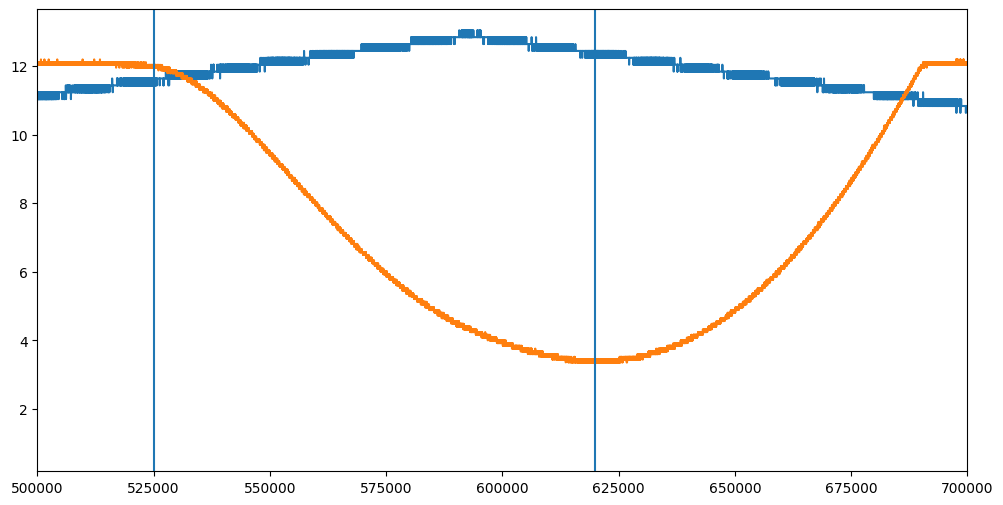

In [834]:
t,v = AdquirirOnda(scope,3)
t,p = AdquirirOnda(scope,1)
plt.plot(v+7)
plt.plot(p)
#plt.plot(v,p)

plt.xlim(0.5e6,0.7e6)

plt.axvline(525000)
plt.axvline(620000)

print(f'vmax: {v[525000]}')
print(f'vmin: {v[620000]}')

In [810]:
np.mean(np.array([1,2]))

1.5

In [781]:
len(y)/(nsimbolos)/SPS

0.8